In [1]:
# Load pyspark
import findspark

findspark.init()

from pyspark import SparkContext

from pyspark.sql import SparkSession
from pyspark.sql import functions as F

from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import RandomForestRegressor

from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, StandardScaler

from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from pyspark.ml import Pipeline

In [2]:
import pandas as pd
import numpy as np

# charting
import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [3]:
spark = SparkSession.builder.appName("dengue").getOrCreate()

### Chargement des données

In [4]:
path_to_data = "data/"

df_features = spark.read.csv(path_to_data + "dengue_features_train.csv",
                             header=True)
df_labels = spark.read.csv(path_to_data + "dengue_labels_train.csv",
                           header=True)

In [5]:
df_features.printSchema()

root
 |-- city: string (nullable = true)
 |-- year: string (nullable = true)
 |-- weekofyear: string (nullable = true)
 |-- week_start_date: string (nullable = true)
 |-- ndvi_ne: string (nullable = true)
 |-- ndvi_nw: string (nullable = true)
 |-- ndvi_se: string (nullable = true)
 |-- ndvi_sw: string (nullable = true)
 |-- precipitation_amt_mm: string (nullable = true)
 |-- reanalysis_air_temp_k: string (nullable = true)
 |-- reanalysis_avg_temp_k: string (nullable = true)
 |-- reanalysis_dew_point_temp_k: string (nullable = true)
 |-- reanalysis_max_air_temp_k: string (nullable = true)
 |-- reanalysis_min_air_temp_k: string (nullable = true)
 |-- reanalysis_precip_amt_kg_per_m2: string (nullable = true)
 |-- reanalysis_relative_humidity_percent: string (nullable = true)
 |-- reanalysis_sat_precip_amt_mm: string (nullable = true)
 |-- reanalysis_specific_humidity_g_per_kg: string (nullable = true)
 |-- reanalysis_tdtr_k: string (nullable = true)
 |-- station_avg_temp_c: string (nulla

In [6]:
df_labels.printSchema()

root
 |-- city: string (nullable = true)
 |-- year: string (nullable = true)
 |-- weekofyear: string (nullable = true)
 |-- total_cases: string (nullable = true)



### Jointure

Nous joignons les deux DataFrames

In [7]:
#join
df_train = df_features.join(df_labels, ['city', 'year', 'weekofyear'])

print("df_train = ({}, {})".format(df_train.count(), len(df_train.columns)))

df_train = (1456, 25)


### Nettoyage

In [8]:
# The 2 columns 'precipitation_amt_mm' and 'reanalysis_sat_precip_amt_mm' are the same
# we drop 'precipitation_amt_mm'
df_train = df_train.drop('precipitation_amt_mm')

# recast 'week_start_date' as a date. Nice to have for plotting or time series analysis
df_train = df_train.withColumn('week_start_date', F.to_date('week_start_date', 'yyyy-MM-dd'))

# recast 'year' and 'weekofyear' to integer
df_train = df_train \
    .withColumn('year', df_train['year'].cast('int')) \
    .withColumn('weekofyear', df_train['weekofyear'].cast('int'))

# cast column to float
for col_name in df_train.columns[4:]:
    df_train = df_train.withColumn(col_name, df_train[col_name].cast('float'))

In [9]:
print("df_train = ({}, {})".format(df_train.count(), len(df_train.columns)))

# identify null value
for col_name in df_train.columns:
    print("{} => {}".format(col_name,
                            df_train.filter(F.isnull(df_train[col_name])).count()))
    
df_train = df_train.dropna()

print("df_train = ({}, {})".format(df_train.count(), len(df_train.columns)))

df_train = (1456, 24)
city => 0
year => 0
weekofyear => 0
week_start_date => 0
ndvi_ne => 194
ndvi_nw => 52
ndvi_se => 22
ndvi_sw => 22
reanalysis_air_temp_k => 10
reanalysis_avg_temp_k => 10
reanalysis_dew_point_temp_k => 10
reanalysis_max_air_temp_k => 10
reanalysis_min_air_temp_k => 10
reanalysis_precip_amt_kg_per_m2 => 10
reanalysis_relative_humidity_percent => 10
reanalysis_sat_precip_amt_mm => 13
reanalysis_specific_humidity_g_per_kg => 10
reanalysis_tdtr_k => 10
station_avg_temp_c => 43
station_diur_temp_rng_c => 43
station_max_temp_c => 20
station_min_temp_c => 14
station_precip_mm => 22
total_cases => 0
df_train = (1199, 24)


In [10]:
df_train.printSchema()

root
 |-- city: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- weekofyear: integer (nullable = true)
 |-- week_start_date: date (nullable = true)
 |-- ndvi_ne: float (nullable = true)
 |-- ndvi_nw: float (nullable = true)
 |-- ndvi_se: float (nullable = true)
 |-- ndvi_sw: float (nullable = true)
 |-- reanalysis_air_temp_k: float (nullable = true)
 |-- reanalysis_avg_temp_k: float (nullable = true)
 |-- reanalysis_dew_point_temp_k: float (nullable = true)
 |-- reanalysis_max_air_temp_k: float (nullable = true)
 |-- reanalysis_min_air_temp_k: float (nullable = true)
 |-- reanalysis_precip_amt_kg_per_m2: float (nullable = true)
 |-- reanalysis_relative_humidity_percent: float (nullable = true)
 |-- reanalysis_sat_precip_amt_mm: float (nullable = true)
 |-- reanalysis_specific_humidity_g_per_kg: float (nullable = true)
 |-- reanalysis_tdtr_k: float (nullable = true)
 |-- station_avg_temp_c: float (nullable = true)
 |-- station_diur_temp_rng_c: float (nullable = true)
 

### Plot

In [11]:
# create pandas dataframe from spark dataframe

pd_train = df_train.toPandas()

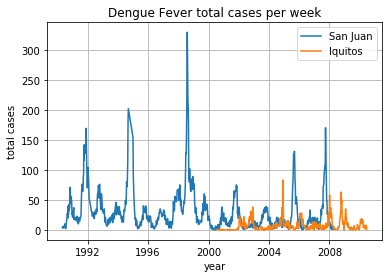

In [12]:
pd_train_sj = pd_train[pd_train['city'] == 'sj']
pd_train_iq = pd_train[pd_train['city'] == 'iq']

# Total cases per city
plt.figure()

plt.grid()
plt.title('Dengue Fever total cases per week')


plt.xlabel('year')
plt.ylabel('total cases')
plt.xticks()
plt.yticks()

plt.plot(pd_train_sj['week_start_date'], pd_train_sj['total_cases'], label='San Juan')
plt.plot(pd_train_iq['week_start_date'], pd_train_iq['total_cases'], label='Iquitos')

plt.legend()

plt.show()

### Construction des jeux d'entrainement et de test

In [13]:
train, test = df_train.randomSplit([0.75, 0.25], seed=18)

train.cache()

DataFrame[city: string, year: int, weekofyear: int, week_start_date: date, ndvi_ne: float, ndvi_nw: float, ndvi_se: float, ndvi_sw: float, reanalysis_air_temp_k: float, reanalysis_avg_temp_k: float, reanalysis_dew_point_temp_k: float, reanalysis_max_air_temp_k: float, reanalysis_min_air_temp_k: float, reanalysis_precip_amt_kg_per_m2: float, reanalysis_relative_humidity_percent: float, reanalysis_sat_precip_amt_mm: float, reanalysis_specific_humidity_g_per_kg: float, reanalysis_tdtr_k: float, station_avg_temp_c: float, station_diur_temp_rng_c: float, station_max_temp_c: float, station_min_temp_c: float, station_precip_mm: float, total_cases: float]

### Construction du *pipeline*

In [14]:
indexer = StringIndexer(inputCol='city', outputCol='city_')

encoder = OneHotEncoder(inputCol='city_', outputCol='cityVect')

vectorAssembler = VectorAssembler(
    inputCols=['year', 'weekofyear',
               'ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw',
               'reanalysis_air_temp_k','reanalysis_avg_temp_k',
               'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k',
               'reanalysis_min_air_temp_k', 'reanalysis_precip_amt_kg_per_m2',
               'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
               'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
               'station_avg_temp_c','station_diur_temp_rng_c',
               'station_max_temp_c', 'station_min_temp_c', 
               'station_precip_mm', 'cityVect'], 
    outputCol = 'features')

scaler = StandardScaler(inputCol='features',
                        outputCol="scaled_features",
                        withStd=True, withMean=True)

lr = LinearRegression(featuresCol='scaled_features',
                      labelCol='total_cases',
                      predictionCol='lr_prediction')

rf = RandomForestRegressor(featuresCol='scaled_features',
                           labelCol='total_cases',
                           predictionCol='rf_prediction')

#### 1. Random Forest

In [15]:
pipeline_rf = Pipeline(stages=[indexer, encoder, vectorAssembler, scaler, rf])

evaluator_rf = RegressionEvaluator(labelCol='total_cases',
                                   predictionCol='rf_prediction',
                                   metricName="rmse")

In [16]:
# build model
model_rf = pipeline_rf.fit(train)

In [17]:
# Build prediction from 'test' dataset
pred_rf = model_rf.transform(test)

In [18]:
pred_rf.select(['total_cases','rf_prediction']).show(150)

+-----------+------------------+
|total_cases|     rf_prediction|
+-----------+------------------+
|        0.0|2.4253321431975543|
|        0.0| 2.253886077186271|
|        0.0| 4.251999889369077|
|        1.0| 4.306276699515452|
|        0.0|4.9291346846916415|
|        0.0| 6.099643024466036|
|        0.0| 6.644658456782811|
|        0.0|10.262279501159238|
|        0.0|4.8794314098218035|
|        0.0| 4.008365405022072|
|        0.0|  5.79182976819262|
|        0.0| 5.968138152408761|
|        1.0| 2.189979075050777|
|        0.0|1.9952238302955323|
|        0.0|2.6129866987868926|
|        0.0|2.3725771083773024|
|        0.0| 8.144774436745845|
|        0.0| 8.613560436355801|
|        1.0| 7.990521025663632|
|        1.0| 11.85968721057355|
|       11.0| 9.690618112105538|
|       14.0| 7.368506962148483|
|       10.0| 8.992875988181678|
|       10.0|  7.76012969003921|
|       10.0| 7.636239617106246|
|        7.0| 5.050187778823358|
|       18.0| 7.298792073294318|
|       10

In [19]:
rmse = evaluator_rf.evaluate(pred_rf)

print("Random Forest::Before grid search - RMSE = {:.3f}".format(rmse))

Random Forest::Before grid search - RMSE = 22.335


#### Cross-Validation

In [20]:
# Parameter grid for random forest
paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [2, 5, 10, 15, 20]) \
    .addGrid(rf.numTrees, [10, 20, 30, 40, 50]) \
    .build()

crossval_rf = CrossValidator(estimator=pipeline_rf,
                             estimatorParamMaps=paramGrid_rf,
                             evaluator=evaluator_rf,
                             numFolds=2,
                             seed=18)

In [21]:
cv_model_rf = crossval_rf.fit(train)

In [22]:
# Build prediction from 'test' dataset
cv_pred_rf = cv_model_rf.transform(test)

In [23]:
rmse = evaluator_rf.evaluate(cv_pred_rf)

print("Random Forest::After grid search - RMSE = {:.3f}".format(rmse))

Random Forest::After grid search - RMSE = 20.452


In [24]:
cv_model_rf.bestModel.stages[-1].getNumTrees

40

#### plot

In [35]:
# create pandas dataframe from spark dataframe
pd_pred_rf = cv_pred_rf.toPandas()

pd_pred_rf_sj = pd_pred_rf[pd_pred_rf['city'] == 'sj']
pd_pred_rf_iq = pd_pred_rf[pd_pred_rf['city'] == 'iq']

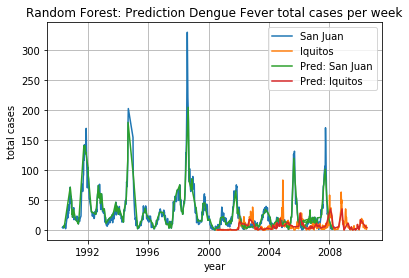

In [36]:
# Total cases per city
plt.figure()

plt.grid()
plt.title('Random Forest: Prediction Dengue Fever total cases per week')


plt.xlabel('year')
plt.ylabel('total cases')
plt.xticks()
plt.yticks()

plt.plot(pd_train_sj['week_start_date'], pd_train_sj['total_cases'], label='San Juan')
plt.plot(pd_train_iq['week_start_date'], pd_train_iq['total_cases'], label='Iquitos')

plt.plot(pd_pred_rf_sj['week_start_date'], pd_pred_rf_sj['total_cases'], label='Pred: San Juan')
plt.plot(pd_pred_rf_iq['week_start_date'], pd_pred_rf_iq['total_cases'], label='Pred: Iquitos')

plt.legend()

plt.show()

#### 2. Linear regression

In [26]:
pipeline_lr = Pipeline(stages=[indexer, encoder, vectorAssembler, scaler, lr])

evaluator_lr = RegressionEvaluator(labelCol='total_cases',
                                   predictionCol='lr_prediction',
                                   metricName="rmse")

In [27]:
model_lr = pipeline_lr.fit(train)

In [28]:
# Build prediction from 'test' dataset
pred_lr = model_lr.transform(test)

In [29]:
pred_lr.select(['total_cases','lr_prediction']).show(10)

+-----------+-------------------+
|total_cases|      lr_prediction|
+-----------+-------------------+
|        0.0|  5.309805224413651|
|        0.0| 2.1296964967743612|
|        0.0|   9.46266650831906|
|        1.0| 3.9790872846221212|
|        0.0|  23.61227055126312|
|        0.0| 23.992805141601696|
|        0.0|-0.8077976913743257|
|        0.0| -2.812901654584966|
|        0.0|  7.502128494561031|
|        0.0|  6.336783396109944|
+-----------+-------------------+
only showing top 10 rows



In [30]:
rmse = evaluator_lr.evaluate(pred_lr)

print("Linear regression::Before grid search - RMSE = {:.3f}".format(rmse))

Linear regression::Before grid search - RMSE = 24.514


#### Cross-Validation

In [31]:
# Parameter grid for linear regression (LR)
paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.fitIntercept, [False, True]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

crossval_lr = CrossValidator(estimator=pipeline_lr,
                             estimatorParamMaps=paramGrid_lr,
                             evaluator=evaluator_lr,
                             numFolds=2,
                             seed=18)

In [32]:
cv_model_lr = crossval_lr.fit(train)

In [33]:
# Build prediction from 'test' dataset
cv_pred_lr = cv_model_lr.transform(test)

In [34]:
rmse = evaluator_lr.evaluate(cv_pred_lr)

print("Linear regression::After grid search - RMSE = {:.3f}".format(rmse))

Linear regression::After grid search - RMSE = 24.623
